# Week08 - ROC AUC

## Introduction and Overview


In this notebook, we will reuse the the Universal Bank dataset.

In this notebook, we will explore assessing a decision tree using ROC curve.

## Step 1: Install and import necessary packages

random_seed = 1
np.random.seed(random_seed)

In [2]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, plot_roc_curve, roc_auc_score, roc_curve, auc, RocCurveDisplay, PrecisionRecallDisplay, precision_recall_curve
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV


In [3]:
random_seed = 1
np.random.seed(random_seed)

## Step 2: Load, clean and prepare data


### 2.1 Read data (income.csv)

In [4]:
df = pd.read_csv('https://github.com/timcsmith/MIS536-Public/raw/master/Data/UniversalBank.csv')
df

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,1,25,1,49,91107,4,1.6,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1.5,1,0,0,1,0,0,0
2,3,39,15,11,94720,1,1.0,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,2.7,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1.0,2,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,4996,29,3,40,92697,1,1.9,3,0,0,0,0,1,0
4996,4997,30,4,15,92037,4,0.4,1,85,0,0,0,1,0
4997,4998,63,39,24,93023,2,0.3,3,0,0,0,0,0,0
4998,4999,65,40,49,90034,3,0.5,2,0,0,0,0,1,0


### 2.2 Explore the dataset

In [5]:
# Explore the dataset
# read the first row of the dataset 
print(df.head())
print(df.columns)
print(df.describe())
print(df.info())

   ID  Age  Experience  Income  ZIP Code  Family  CCAvg  Education  Mortgage  \
0   1   25           1      49     91107       4    1.6          1         0   
1   2   45          19      34     90089       3    1.5          1         0   
2   3   39          15      11     94720       1    1.0          1         0   
3   4   35           9     100     94112       1    2.7          2         0   
4   5   35           8      45     91330       4    1.0          2         0   

   Personal Loan  Securities Account  CD Account  Online  CreditCard  
0              0                   1           0       0           0  
1              0                   1           0       0           0  
2              0                   0           0       0           0  
3              0                   0           0       0           0  
4              0                   0           0       0           1  
Index(['ID', 'Age', 'Experience', 'Income', 'ZIP Code', 'Family', 'CCAvg',
       'Education'

### 2.3 Clean/transform data (where necessary)

In [6]:
# based on findings from data exploration, we need to clean up colum names, as there are some leading whitespace characters
df.columns = [s.strip() for s in df.columns] 
df.columns

Index(['ID', 'Age', 'Experience', 'Income', 'ZIP Code', 'Family', 'CCAvg',
       'Education', 'Mortgage', 'Personal Loan', 'Securities Account',
       'CD Account', 'Online', 'CreditCard'],
      dtype='object')

Drop the columns we are not using as predictors (see previous notebooks -- we are given a subset of input variables to consider)

In [7]:
df = df.drop(columns=['ID', 'ZIP Code'])
df

,Age,Experience,Income,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,25,1,49,4,1.6,1,0,0,1,0,0,0
1,45,19,34,3,1.5,1,0,0,1,0,0,0
2,39,15,11,1,1.0,1,0,0,0,0,0,0
3,35,9,100,1,2.7,2,0,0,0,0,0,0
4,35,8,45,4,1.0,2,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
4995,29,3,40,1,1.9,3,0,0,0,0,1,0
4996,30,4,15,4,0.4,1,85,0,0,0,1,0
4997,63,39,24,2,0.3,3,0,0,0,0,0,0
4998,65,40,49,3,0.5,2,0,0,0,0,1,0


In [8]:
# translation education categories into dummy vars
df['Education'] = df['Education'].astype('category')
df = pd.get_dummies(df, prefix_sep='_', drop_first=False)

### 2.4 Check distribution of classes

Data imbalance is a big concern for decision trees, but it is informative to know the distribution of classes (in this case, two classes)

In [9]:
df['Personal Loan'].value_counts()

0    4520
1     480
Name: Personal Loan, dtype: int64

## Step 3 Split data intro training and validation sets

In [10]:
# construct datasets for analysis
target = 'Personal Loan'
predictors = list(df.columns)
predictors.remove(target)
X = df[predictors]
y = df[target]


In [11]:
# create the training set and the test set 
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=1)

## Step 4: Prediction with Decision Tree 



You can find details about SKLearm's DecisionTree classifier [here](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html).

In [12]:
dtree=DecisionTreeClassifier(random_state=random_seed, max_depth=2) # this isn't a 'tuned' model, but it's a good starting point to demonstrate ROD and AUC
_ = dtree.fit(X_train, y_train)
dtree.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 2,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 1,
 'splitter': 'best'}

In [13]:
y_pred = dtree.predict(X_test)
print("***********************")
print(f"{'Recall Score:':18}{recall_score(y_test, y_pred):.3f}")
print("***********************")
print(f"{'Accuracy Score: ':18}{accuracy_score(y_test, y_pred):.3f}")
print(f"{'Precision Score: ':18}{precision_score(y_test, y_pred):.3f}")
print(f"{'F1 Score: ':18}{f1_score(y_test, y_pred):.3f}")
print("***********************")

***********************
Recall Score:     0.617
***********************
Accuracy Score:   0.962
Precision Score:  1.000
F1 Score:         0.763
***********************


## ROC AUC

In [14]:
dtree=DecisionTreeClassifier(random_state=random_seed, max_depth=2)
_ = dtree.fit(X_train, y_train)

tps = []
fps = []
tns = []
fns = []  
precs = []
recls = []

tprs = []
fprs = []
thres = []
for threshold in np.arange(0.0, 1.1, 0.1):
    y_pred= dtree.predict_proba(X_test)[:,1]>=threshold
    m = confusion_matrix(y_test, y_pred)
    TP = m[1,1]
    TN = m[0,0]
    FP = m[0,1]
    FN = m[1,0]
    TPR = TP/(TP+FN)
    FPR = FP/(FP+TN)
    recall = TP / (TP+FN)
    precision = TP / (TP+FP)
    tps.append(TP)
    fps.append(FP)
    tns.append(TN)
    fns.append(FN)
    tprs.append(TPR)
    fprs.append(FPR)
    recls.append(recall)
    precs.append(precision)
    thres.append(str(round(threshold,2)))

print(y_test.value_counts())
df = pd.DataFrame(list(zip(thres, tps, fps, tns, fns, fprs, tprs, precs, recls)), columns=['Threshold', 'TP', 'FP', 'TN', 'FN', 'FPR', 'TPR', 'Precision', 'Recall'])
df


0    1351
1     149
Name: Personal Loan, dtype: int64


,Threshold,TP,FP,TN,FN,FPR,TPR,Precision,Recall
0,0.0,149,1351,0,0,1.000000,1.000000,0.099333,1.000000
1,0.1,140,242,1109,9,0.179127,0.939597,0.366492,0.939597
2,0.2,120,76,1275,29,0.056255,0.805369,0.612245,0.805369
3,0.3,92,0,1351,57,0.000000,0.617450,1.000000,0.617450
4,0.4,92,0,1351,57,0.000000,0.617450,1.000000,0.617450
5,0.5,92,0,1351,57,0.000000,0.617450,1.000000,0.617450
6,0.6,92,0,1351,57,0.000000,0.617450,1.000000,0.617450
7,0.7,92,0,1351,57,0.000000,0.617450,1.000000,0.617450
8,0.8,92,0,1351,57,0.000000,0.617450,1.000000,0.617450
9,0.9,92,0,1351,57,0.000000,0.617450,1.000000,0.617450


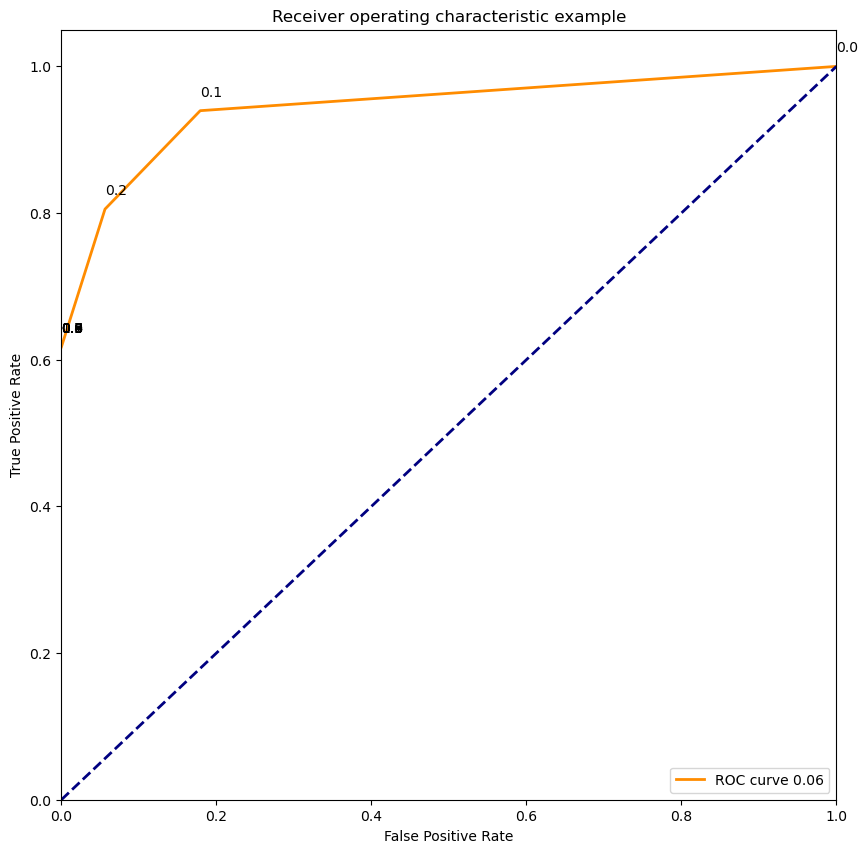

In [15]:
# compute roc auc
roc_auc = auc(tprs, fprs)

plt.figure(figsize=(10,10))
plt.plot(fprs, tprs, color='darkorange', lw=2, label=f'ROC curve {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")

for i in range(len(tprs)):
    plt.annotate(thres[i], (fprs[i], tprs[i] + 0.02))


Using SKLearn 

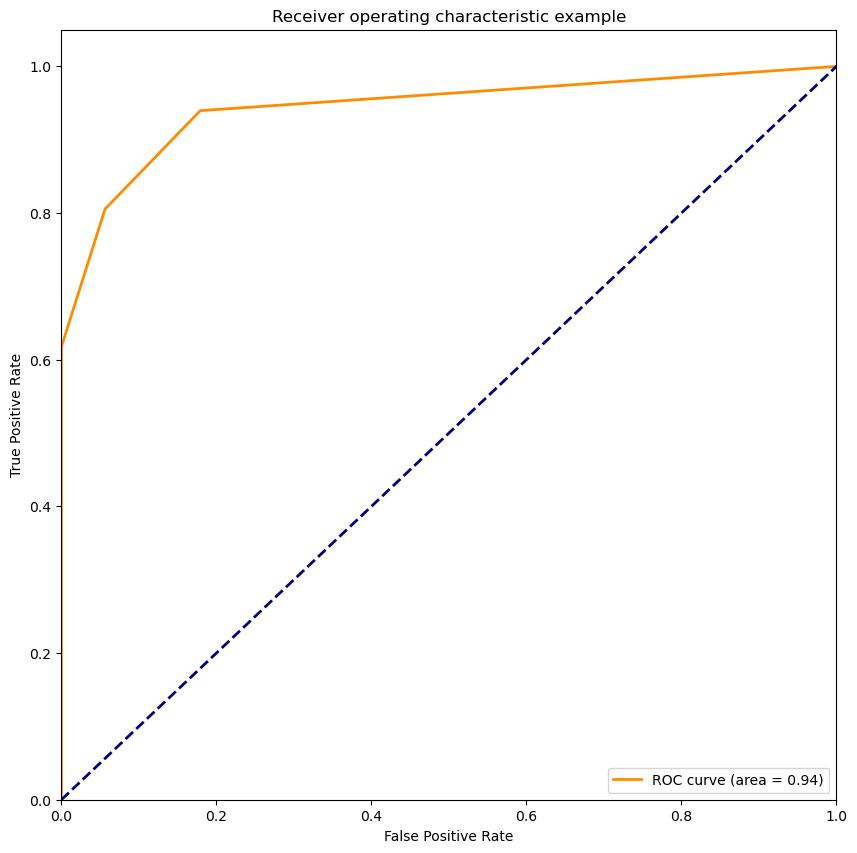

In [16]:
# compute tpr and fpr for for different thresholds
fpr, tpr, thresholds = roc_curve(y_test, dtree.predict_proba(X_test)[:,1])

# compute roc auc
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10,10))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:0.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")

In practice, it's just easier to use the sklearn function method.

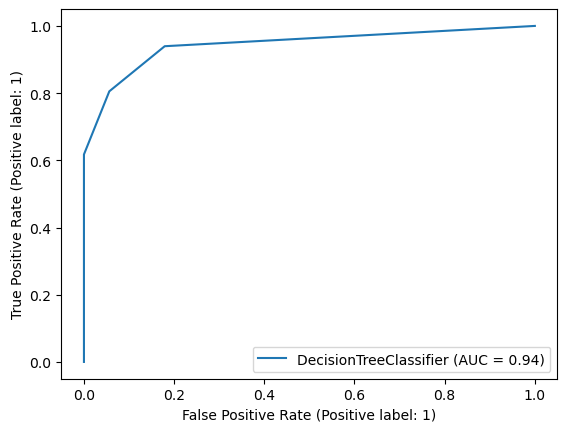

In [17]:
RocCurveDisplay.from_estimator(dtree, X_test, y_test) 
plt.show()

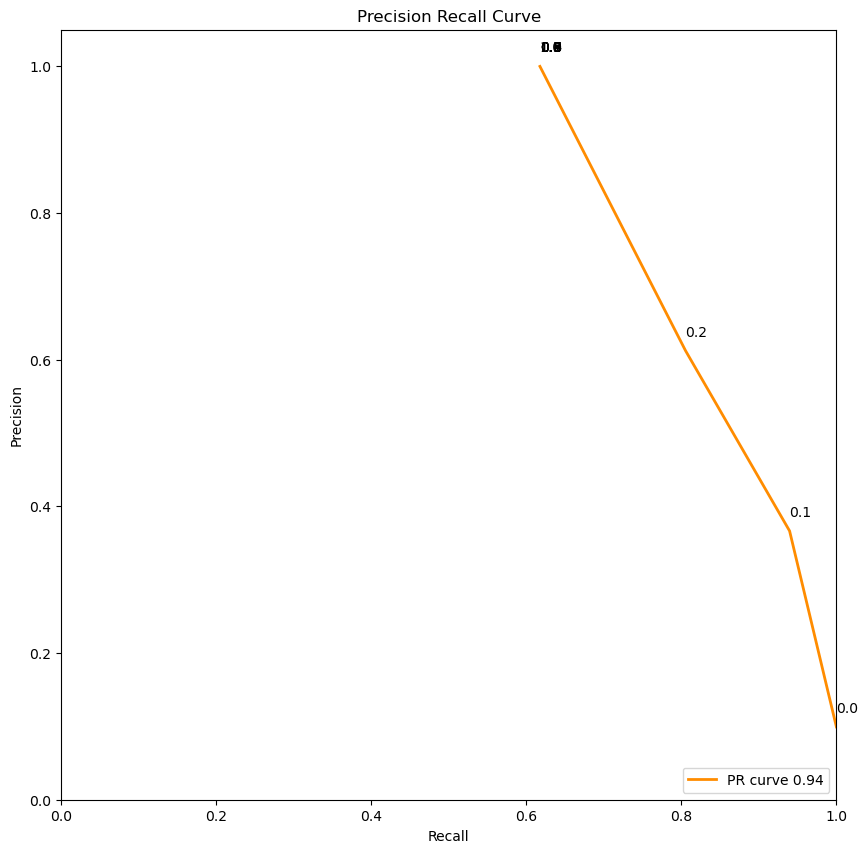

In [18]:
# compute pr auc
pr_auc = auc(recls, precs)

plt.figure(figsize=(10,10))
plt.plot(recls, precs, color='darkorange', lw=2, label=f'PR curve {roc_auc:.2f}')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision Recall Curve')
plt.legend(loc="lower right")

for i in range(len(tprs)):
    plt.annotate(thres[i], (recls[i], precs[i] + 0.02))
    

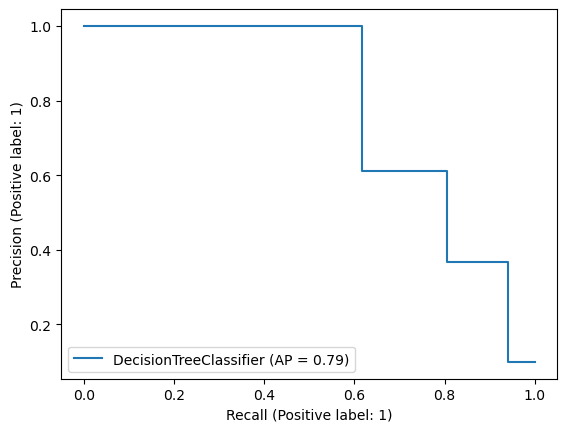

In [19]:
PrecisionRecallDisplay.from_estimator(dtree, X_test, y_test) 
plt.show()

## Step 6: Summarize results    

As usual -- in this section you provide a recap your approach, results, and discussion of findings. 
